# WaveletRingClean in python demonstration
This is a first hello world demonstration of the MorphSotClean python bindings.

You will:
- Load the modules
- Load projection data
- Normalize the projections
- Remove stripes

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import pymuhrec.utils.readers as io
import pymuhrec.utils.imageutils as amg


# import nitools.imgalg.muhrectomo as mt
import pymuhrec as ia
%config InlineBackend.figure_format = 'retina'

## The imgalg.MorphSpotClean class


_imgalg_.MorphSpotClean()
> Constructor

_imgalg.MorphSpotClean_.useThreading(bool) 
> Switches the use of threaded processing.
> Valid values True/False


## Create a reconstructor object

In [3]:
help(ia)

Help on module nitools.imgalg.imgalg in nitools.imgalg:

NAME
    nitools.imgalg.imgalg

CLASSES
    builtins.Exception(builtins.BaseException)
        ImagingException
    pybind11_builtins.pybind11_object(builtins.object)
        AverageImage
        MorphSpotClean
        NormalizeImage
        PolynomialCorrection
        ProjectionFilter
        StripeFilter
        TomoCenter
        eCenterEstimator
        eMorphCleanMethod
        eMorphDetectionMethod
        eProjectionFilterType
        eStripeFilterOperation
    
    class AverageImage(pybind11_builtins.pybind11_object)
     |  Method resolution order:
     |      AverageImage
     |      pybind11_builtins.pybind11_object
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(...)
     |      __init__(self: nitools.imgalg.imgalg.AverageImage) -> None
     |  
     |  process(...)
     |      process(self: nitools.imgalg.imgalg.AverageImage, img: numpy.ndarray[numpy.float32], method: Im

In [3]:
sf = ia.StripeFilter([100,100],"daub7",4,0.05)

help(sf)

Help on StripeFilter in module imgalg object:

class StripeFilter(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      StripeFilter
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(...)
 |      __init__(self: imgalg.StripeFilter, dims: List[int], wname: str, scale: int, wcut: float) -> None
 |
 |      Initializes the stripe filter.
 |
 |  configure(...)
 |      configure(self: imgalg.StripeFilter, dims: List[int], wname: str, scale: int, wcut: float) -> None
 |
 |      Configures the stripe filter. Note: the dims are given in x,y instead of r,c.
 |
 |  decompositionLevels(...)
 |      decompositionLevels(self: imgalg.StripeFilter) -> int
 |
 |  dims(...)
 |      dims(self: imgalg.StripeFilter) -> List[int]
 |
 |  filterWindow(...)
 |      filterWindow(self: imgalg.StripeFilter, arg0: int) -> List[float]
 |
 |  process(...)
 |      process(self: imgalg.StripeFilter, x: numpy.ndarray[numpy.float32], op: Imag

### Testing some parameters

In [4]:
# Sinogram dimensions
sf.dims()

[100, 100]

Inspect the filter windows for each level

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\christianvedel\AppData\Local\Temp\ipykernel_25708\3786243869.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.title("Filter windows for $\sigma$={0:0.3f}".format(sf.sigma()))


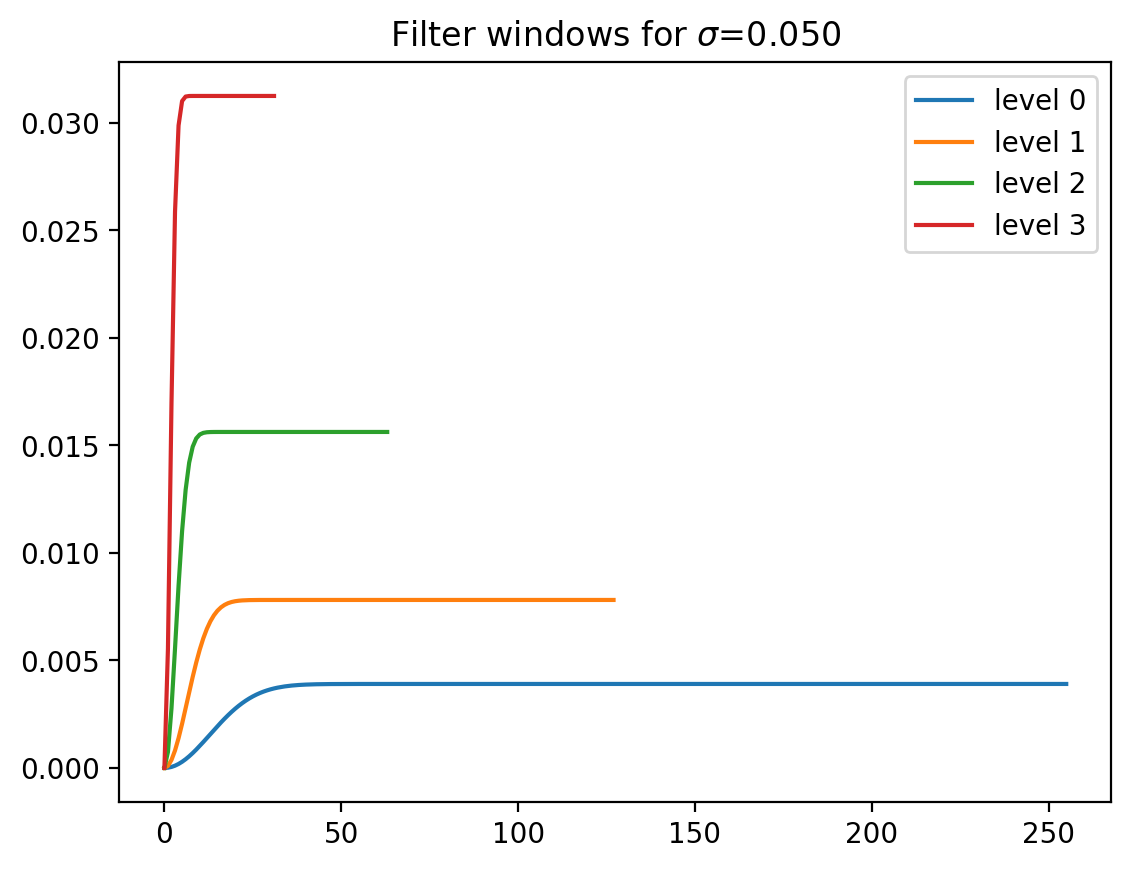

In [5]:
for i in range(sf.decompositionLevels()) :
    plt.plot(sf.filterWindow(i),label=r'level {0}'.format(i))   

plt.title("Filter windows for $\sigma$={0:0.3f}".format(sf.sigma()))
plt.legend();

## Cleaning workflow

### Load data (The wood data)
The wood data is the data I use a lot for demos, tests, and tutorials. It a piece of petrified wood [DOI](http://dx.doi.org/10.17632/g5snr785xy.2). 

In [6]:
data_path = "C:/Users/christianvedel/Imaging/NeutronImaging_test/TestData/"

In [8]:
proj = rd.read_images(data_path+"2D/tiff/tomo/04_ct5s375_128lines/ct5s_{0:05d}.tif",first=1, last=376).astype('float32')

print("proj.shape=",proj.shape)

  0%|          | 0/376 [00:00<?, ?it/s]

proj.shape= (376, 128, 835)


In [9]:
sf2=ia.StripeFilter([proj.shape[2],proj.shape[0]],"daub7",2,0.1)

p2=proj.copy().astype("float32")
sf2.process(p2,ia.eStripeFilterOperation.VerticalComponentFFT)

#### Load projection data

In [12]:
ob = io.read_images(data_path+'2D/tiff/tomo/04_ct5s375_128lines/ob_{0:05d}.tif',1,10,averageStack=True).mean(axis=0)
dc = io.read_images(data_path+'2D/tiff/tomo/04_ct5s375_128lines/dc_{0:05d}.tif',1,10,averageStack=True).mean(axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

#### Inspecting the data

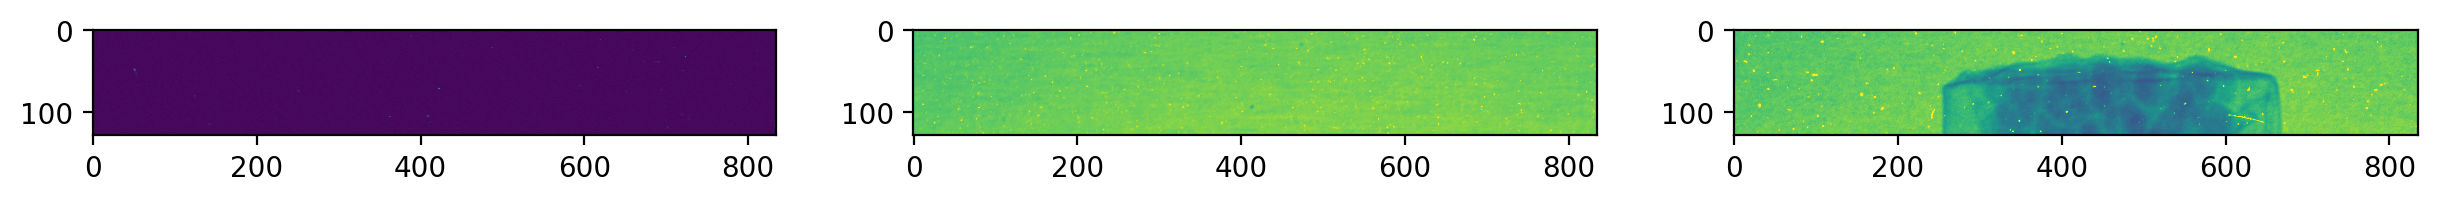

In [13]:
fig,ax = plt.subplots(1,3,figsize=[15,7])
ax[0].imshow(dc)
ax[1].imshow(ob,vmin=300,vmax=2000)
ax[2].imshow(proj[0],vmin=300,vmax=2000);

## Preprocessing
Here the projections needs to be prepared for reconstruction. Typical operations are 
- Cropping
- Normalization (possibly with scattering correction)

### Normalize 
Create a image normalization instance from the imaging algorithms package. Here with short name _ia_.



In [14]:
norm = ia.NormalizeImage(True) # True for use logarithm
norm.setReferences(ob,dc)
cproj = proj.copy()
norm.process(cproj)

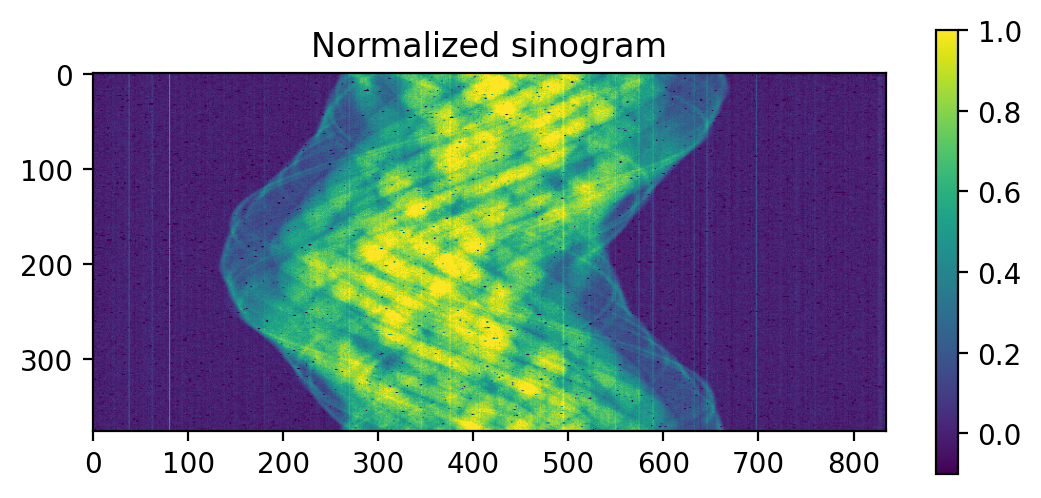

In [15]:
fig,axes=plt.subplots(1)
a0=axes.imshow(cproj[:,64,:], vmin=-0.1,vmax=1); 
axes.set_title('Normalized sinogram')
fig.colorbar(a0,ax=axes,shrink=0.6);


## Cleaning the sinogram

In [16]:
sf = ia.StripeFilter([cproj.shape[2],cproj.shape[0]],"daub17",2,0.01)
cleaned = cproj.copy()

sf2.process(cleaned,ia.eStripeFilterOperation.VerticalComponentFFT)

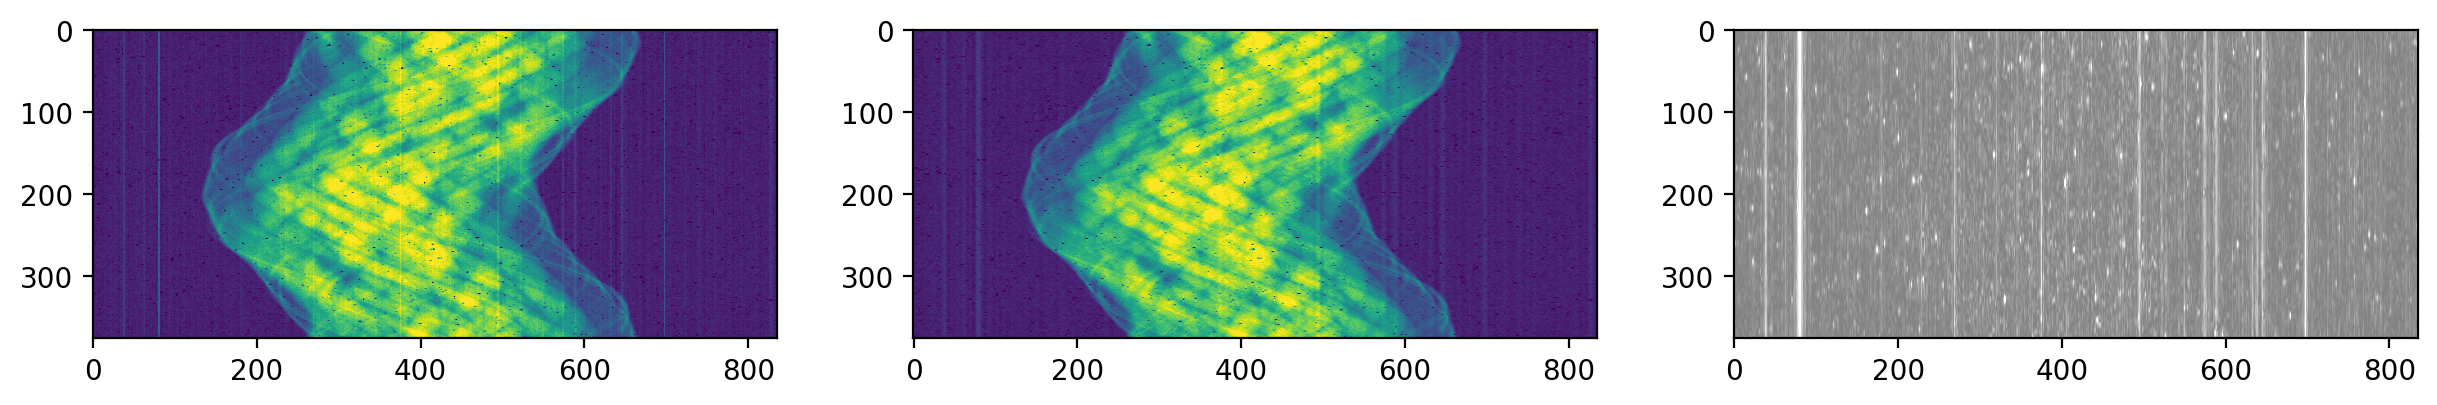

In [17]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].imshow(cproj[:,64,:], vmin=-0.1,vmax=1); 
ax[1].imshow(cleaned[:,64,:], vmin=-0.1,vmax=1); 
ax[2].imshow(abs(cproj[:,64,:]-cleaned[:,64,:]), vmin=-0.1,vmax=0.1,cmap='gray'); 

In [69]:
The ring cleaning should ideally be done using spot cleaning prior to running the filter.